###### ### The University of Melbourne, School of Computing and Information Systems
# COMP30027 Machine Learning, 2024 Semester 1

## Assignment 2: IMDB Movie Rating Prediction


**Student ID(s):** 1353623


## **TEXT PREPROCESSING**

In [357]:
# Selecting features to normalize
import pandas as pd

def columns_with_large_range(df):
    large_range_columns = []
    
    # Get numerical columns
    numerical_columns = df.select_dtypes(include=['number']).columns

    # Loop through numerical columns
    for col in numerical_columns:
        # Calculate range
        col_range = df[col].max() - df[col].min()
        
        # Check if range is greater than 10,000
        if col_range > 10000:
            large_range_columns.append(col)

    return large_range_columns

# Read the dataset
data = pd.read_csv('train_dataset.csv')

# Get columns with range greater than 10,000
columns_with_range_greater_than_10000 = columns_with_large_range(data)

# View the columns
print(columns_with_range_greater_than_10000)

['director_facebook_likes', 'actor_3_facebook_likes', 'actor_1_facebook_likes', 'gross', 'num_voted_users', 'cast_total_facebook_likes', 'actor_2_facebook_likes', 'movie_facebook_likes']


In [361]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MultiLabelBinarizer

# Clean and format 'genres' and 'plot_keywords' columns
def clean_column(column):
    # Split values by '|'
    column = column.str.split('|')
    # Join the lists of strings into a single string separated by '|'
    column = column.apply(lambda x: '|'.join(x))
    # Strip leading and trailing whitespace from the resulting string
    column = column.str.strip()
    return column

# Read the original dataset from the CSV file
train_df = pd.read_csv('train_dataset.csv')
test_df = pd.read_csv('test_dataset.csv')

# Apply cleaning function to 'genres' and 'plot_keywords' columns for both train and test
train_df['genres'] = clean_column(train_df['genres'])
train_df['plot_keywords'] = clean_column(train_df['plot_keywords'])

test_df['genres'] = clean_column(test_df['genres'])
test_df['plot_keywords'] = clean_column(test_df['plot_keywords'])

# Remove rows with no genres or no plot_keywords for train data
train_df = train_df[(train_df['genres'].apply(lambda x: len(x) > 0)) & (train_df['plot_keywords'].apply(lambda x: len(x) > 0))]

# Specify the columns you want to normalize
columns_to_normalize = ['director_facebook_likes', 'actor_3_facebook_likes', 'actor_1_facebook_likes', 'gross',
                        'num_voted_users', 'cast_total_facebook_likes', 'actor_2_facebook_likes', 'movie_facebook_likes']

# Normalize the specified columns for both train and test data
scaler = StandardScaler()
train_df[columns_to_normalize] = scaler.fit_transform(train_df[columns_to_normalize])
test_df[columns_to_normalize] = scaler.transform(test_df[columns_to_normalize])

# Create a MultiLabelBinarizer to encode the genres column
mlb_genres = MultiLabelBinarizer()
train_genres_encoded = mlb_genres.fit_transform(train_df['genres'])
test_genres_encoded = mlb_genres.transform(test_df['genres'])  # Use transform for test data

# Create DataFrames with the encoded genres
train_genres_df = pd.DataFrame(train_genres_encoded, columns=mlb_genres.classes_)
test_genres_df = pd.DataFrame(test_genres_encoded, columns=mlb_genres.classes_)

# Create a MultiLabelBinarizer to encode the plot_keywords column
mlb_keywords = MultiLabelBinarizer()
train_keywords_encoded = mlb_keywords.fit_transform(train_df['plot_keywords'])
test_keywords_encoded = mlb_keywords.transform(test_df['plot_keywords'])  # Use transform for test data

# Create DataFrames with the encoded plot_keywords
train_keywords_df = pd.DataFrame(train_keywords_encoded, columns=mlb_keywords.classes_)
test_keywords_df = pd.DataFrame(test_keywords_encoded, columns=mlb_keywords.classes_)

# Concatenate the encoded genres and plot_keywords DataFrames with the original DataFrames
train_df_encoded = pd.concat([train_df, train_genres_df, train_keywords_df], axis=1)
test_df_encoded = pd.concat([test_df, test_genres_df, test_keywords_df], axis=1)

# Drop the original genres and plot_keywords columns if needed
train_df_encoded.drop(columns=['genres', 'plot_keywords'], inplace=True)
test_df_encoded.drop(columns=['genres', 'plot_keywords'], inplace=True)

# Specify file paths for saving the processed DataFrames
train_csv_file_path = "train_df_processed.csv"
test_csv_file_path = "test_df_processed.csv"

# Save the processed train DataFrame to a CSV file
train_df_encoded.to_csv(train_csv_file_path, index=False)

# Save the processed test DataFrame to a CSV file
test_df_encoded.to_csv(test_csv_file_path, index=False)

print("Processed DataFrames saved successfully.")


Processed DataFrames saved successfully.


## ** EXPLORATORY DATA ANALYSIS**

## **Media Count vs IMDB Score**

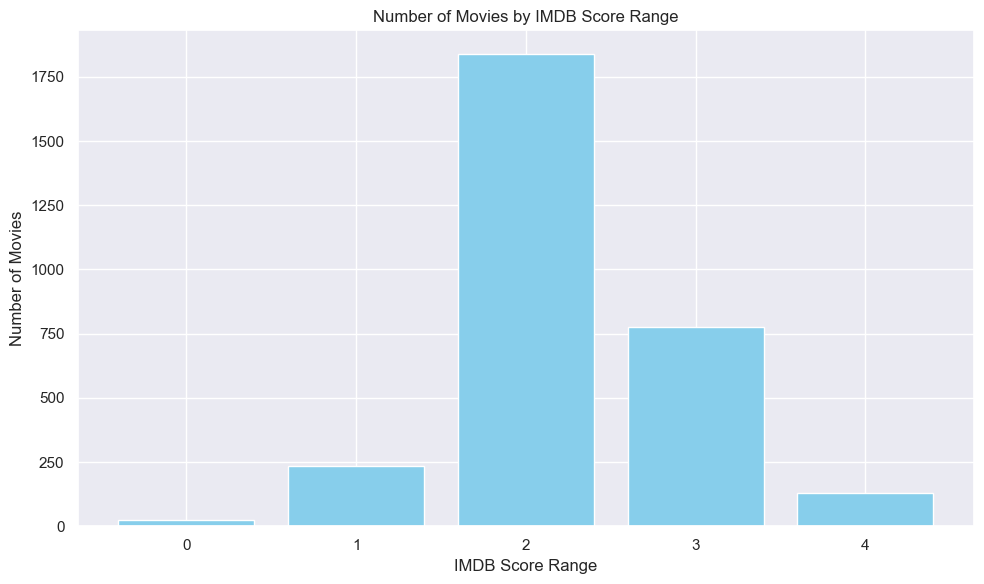

In [196]:
import matplotlib.pyplot as plt
import pandas as pd

# Read the dataset from the CSV file
df = pd.read_csv('train_dataset.csv')

# Calculate the count of movies associated with each IMDb score range
imdb_counts = df['imdb_score_binned'].value_counts().sort_index()

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(imdb_counts.index, imdb_counts.values, color='skyblue')
plt.xlabel('IMDB Score Range')
plt.ylabel('Number of Movies')
plt.title('Number of Movies by IMDB Score Range')
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

## Heatmap

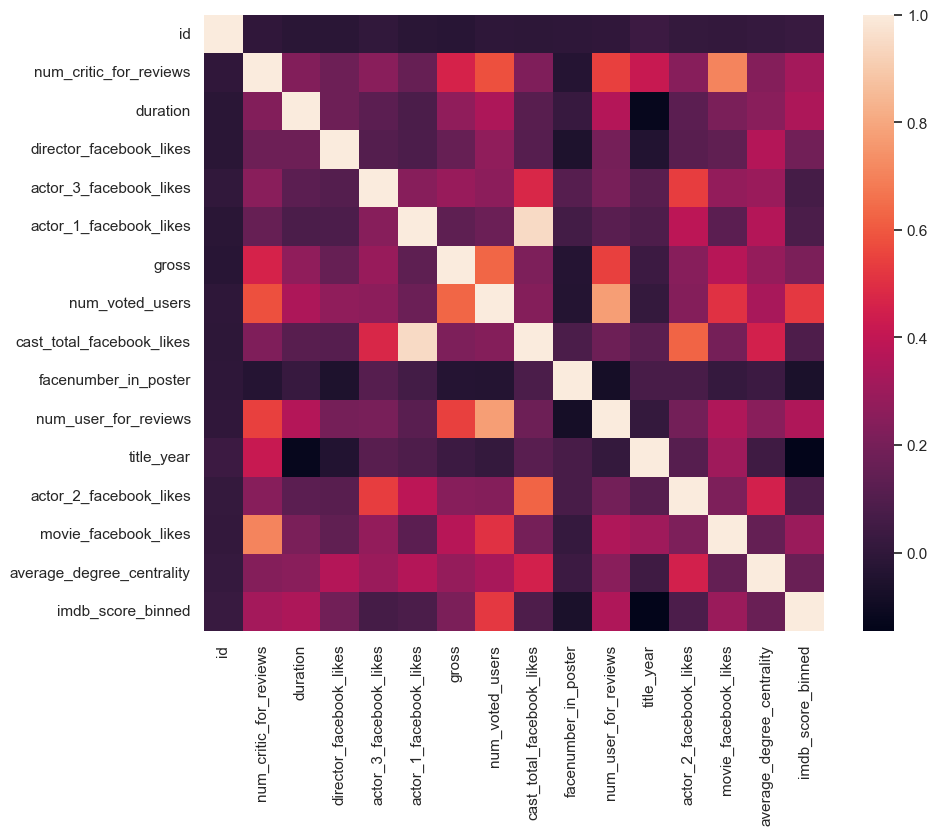

In [197]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size to ensure all annotations are visible
plt.figure(figsize=(10, 8))

# Create the correlation heatmap with smaller font size
sns.heatmap(df_normalized.corr(numeric_only=True), annot=False, fmt=".2f")

 
plt.show()


## Model 1: KNN Classifier

In [388]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.dummy import DummyClassifier  # Import DummyClassifier for Zero-R baseline
import pandas as pd

# Select features for training
selected_features = ['movie_facebook_likes', 'facenumber_in_poster', 'num_critic_for_reviews', 'gross']

# Combine selected features with the encoded genres for training
X_train = pd.concat([train_genres_df, train_df_encoded[selected_features]], axis=1)
y_train = train_df['imdb_score_binned']

# Initialize SelectKBest with ANOVA F-test
selector = SelectKBest(score_func=f_classif, k=4)

# Perform feature selection on the entire training set
X_train_selected = selector.fit_transform(X_train, y_train)

# Get selected feature indices
selected_feature_indices = selector.get_support(indices=True)

# Get selected feature names from the original feature set
selected_feature_names = X_train.columns[selected_feature_indices]

# Reconstruct DataFrames with selected feature names
X_train_selected = pd.DataFrame(X_train_selected, columns=selected_feature_names, index=X_train.index)

# Initialize KNN model
knn_model = KNeighborsClassifier()

# Initialize Stratified K-Fold cross-validator
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# -------------------------
# Calculate Zero-R baseline
# -------------------------
zero_r_model = DummyClassifier(strategy='most_frequent')

# Perform cross-validation to evaluate Zero-R baseline
zero_r_accuracies = cross_val_score(zero_r_model, X_train_selected, y_train, cv=cv, scoring='accuracy')
zero_r_mean_accuracy = zero_r_accuracies.mean()

print(f"Mean Accuracy for Zero-R baseline: {zero_r_mean_accuracy}")

# -------------------------
# Find best k for KNN model
# -------------------------
best_accuracy = 0
best_k = 1

# Iterate over different values of k using cross-validation
for k in range(1, 50):
    knn_model.set_params(n_neighbors=k)
    
    fold_accuracies = []
    
    # Perform cross-validation
    for train_index, val_index in cv.split(X_train_selected, y_train):
        X_train_cv, X_val = X_train_selected.iloc[train_index], X_train_selected.iloc[val_index]
        y_train_cv, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
        
        # Fit the model on the training data for this fold
        knn_model.fit(X_train_cv, y_train_cv)
        
        # Predict on the validation data
        y_pred = knn_model.predict(X_val)
        
        # Calculate accuracy for this fold
        accuracy = accuracy_score(y_val, y_pred)
        fold_accuracies.append(accuracy)
    
    # Calculate mean accuracy across folds
    mean_accuracy = sum(fold_accuracies) / len(fold_accuracies)
    
    # Update best accuracy and k value
    if mean_accuracy > best_accuracy:
        best_accuracy = mean_accuracy
        best_k = k

# Print the best k value and mean accuracy after all iterations
print(f"Best k value: {best_k} with mean accuracy: {best_accuracy}")

# -------------------------
# Evaluate KNN model metrics
# -------------------------
knn_model.set_params(n_neighbors=best_k)
metrics_across_folds = []

# Perform cross-validation for the best k value
for train_index, val_index in cv.split(X_train_selected, y_train):
    X_train_cv, X_val = X_train_selected.iloc[train_index], X_train_selected.iloc[val_index]
    y_train_cv, y_val = y_train.iloc[train_index], y_train.iloc[val_index]

    # Fit the model on the training data for this fold
    knn_model.fit(X_train_cv, y_train_cv)

    # Predict on the validation data
    y_pred = knn_model.predict(X_val)

    # Calculate metrics for this fold
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred, average='weighted', zero_division=0)  # Adjusted for zero division
    recall = recall_score(y_val, y_pred, average='weighted', zero_division=0)  # Adjusted for zero division
    f1 = f1_score(y_val, y_pred, average='weighted', zero_division=0)  # Adjusted for zero division

    # Append metrics to list
    metrics_across_folds.append((accuracy, precision, recall, f1))

# Calculate mean metrics across folds for the best k value
mean_accuracy, mean_precision, mean_recall, mean_f1_score = zip(*metrics_across_folds)
mean_accuracy = sum(mean_accuracy) / len(metrics_across_folds)
mean_precision = sum(mean_precision) / len(metrics_across_folds)
mean_recall = sum(mean_recall) / len(metrics_across_folds)
mean_f1_score = sum(mean_f1_score) / len(metrics_across_folds)

print(f"Metrics for best k = {best_k}:")
print(f"Mean Accuracy: {mean_accuracy}")
print(f"Mean Precision: {mean_precision}")
print(f"Mean Recall: {mean_recall}")
print(f"Mean F1 Score: {mean_f1_score}")

# -------------------------
# Proceed with testing and generating predictions
# -------------------------
# Select features for testing
X_test = pd.concat([test_genres_df, test_df[selected_features]], axis=1)

# Perform SelectKBest feature selection on the test set
X_test_selected = X_test.iloc[:, selected_feature_indices]

# Predict the target variable for the modified test dataset
y_pred_test = knn_model.predict(X_test_selected)

# Create a DataFrame with sequential IDs and the corresponding predictions
df = pd.DataFrame({"id": range(1, len(y_pred_test) + 1), "predicted_imdb_score": y_pred_test})

# Limiting the DataFrame to 752 rows
df = df.head(752)

# Specify the file path where you want to save the CSV file
csv_file_path = "knn_with_cv_and_selectkbest.csv"

# Write the DataFrame to a CSV file
df.to_csv(csv_file_path, index=False)

print("CSV file created successfully.")


Mean Accuracy for Zero-R baseline: 0.6121841375485302
Best k value: 28 with mean accuracy: 0.6241691625069329
Metrics for best k = 28:
Mean Accuracy: 0.6241691625069329
Mean Precision: 0.5210784075494261
Mean Recall: 0.6241691625069329
Mean F1 Score: 0.5251088747734476
CSV file created successfully.


### Model 2: Decision Tree/Bagging

Accuracy: 0.7105
Precision: 0.6918
Recall: 0.7105
F1 Score: 0.6964


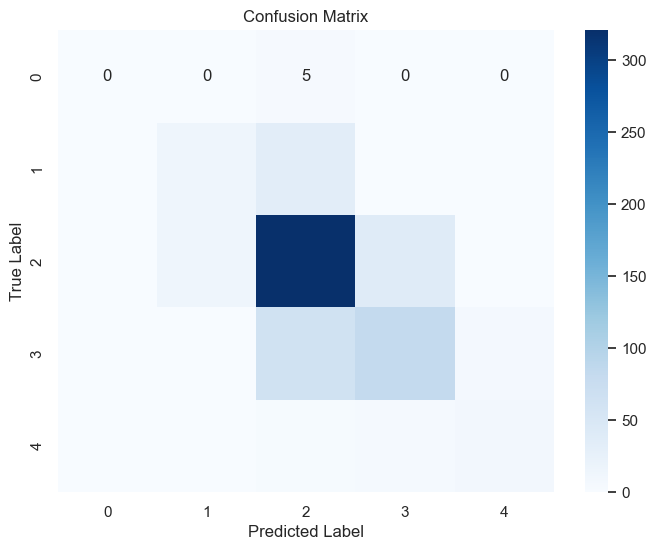

Test predictions saved to CSV file successfully.


In [411]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Assuming train_df_encoded and train_genres_df are defined elsewhere
# Define selected features
selected_features = ['director_facebook_likes', 'actor_3_facebook_likes', 'actor_1_facebook_likes', 'gross',
                     'num_voted_users', 'cast_total_facebook_likes', 'actor_2_facebook_likes', 'movie_facebook_likes']

# Concatenate features for training
X_train = pd.concat([train_genres_df, train_df_encoded[selected_features]], axis=1)
y_train = train_df_encoded['imdb_score_binned']

# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Define the base classifier (Decision Tree)
base_classifier = DecisionTreeClassifier()

# Define the Bagging Classifier
bagging_classifier = BaggingClassifier(estimator=base_classifier, n_estimators=10, random_state=42)

# Train the Bagging Classifier
bagging_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = bagging_classifier.predict(X_test)

# Evaluate performance metrics on the test set
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)

# Print metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=bagging_classifier.classes_,
            yticklabels=bagging_classifier.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Create a DataFrame with sequential IDs and the corresponding rounded predictions
df = pd.DataFrame({"id": range(1, len(y_pred)+1), "predicted_imdb_score": y_pred})

# Limiting the DataFrame to 752 rows (as per your original code)
df = df.head(752)

# Specify the file path where you want to save the CSV file
csv_file_path = "bagging.csv"

# Write the DataFrame to a CSV file
df.to_csv(csv_file_path, index=False)

print("Test predictions saved to CSV file successfully.")
